# Homework 2
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset (CIFAR), and then work our way up to TinyImageNet!

# Initial Setup

In [0]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive/
'My Drive'


In [0]:
# !rm -rf /gdrive/My\ Drive/colab_files/homework2/cifar/checkpoints/wobn
# !ls /gdrive/My\ Drive/colab_files/homework2/tiny_imagenet/

Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.

Have a look at pt_util. We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.

In [0]:
import os

BASE_PATH = '/gdrive/My Drive/colab_files/homework2/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !ls
    !rm homework2.tar
    !cp pt_util.py /content
os.chdir('/content')

/content
sample_data


# CIFAR

## Part 1: Getting the Dataset
Normally, we'd want to download our dataset first. Since PyTorch hosts the CIFAR dataset, we can load it using their helper function later.

But, we'll change DATA_PATH to an empty directory to download the dataset to.

In [0]:
DATA_PATH = BASE_PATH + 'cifar/'

## Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try. Have a look at https://github.com/pytorch/examples/blob/master/mnist/main.py for a basic neural network implementation.


- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

Additionally, the current saving function always saves the latest results. You may want to modify it to only save the results if they have the highest test accuracy. Please make this modification.

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [0]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py

cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        # TODO define the layers
        self.features = self._make_layers(cfg['VGG11'])
        self.classifier = nn.Linear(512, 10)
                
        self.best_acc = 0

    def forward(self, x):
        # TODO define the forward pass
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out
            
    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        # TODO save the model if it is the best
        if accuracy > self.best_acc:
            self.best_acc = accuracy
            pt_util.save(self, file_path, num_to_keep)
            print('Saving new best model w/ test acc: ',accuracy)
      
    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [0]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

## Part 3 and 4: Loading Data and Dataset Augmentation

In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.

In [0]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.

In [0]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 512
TEST_BATCH_SIZE = 128
EPOCHS = 60
# LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 20ㄎ
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log_wobn.pkl'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = CifarNet().to(device)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints/wobn')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        if epoch <= 30:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        else:
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/wobn/%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(DATA_PATH + 'checkpoints/wobn/%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')


---
# TinyImageNet

## Part 1: Upload the Dataset
Change the DATA_PATH to the path of the TinyImageNet dataset we downloaded earlier.

In [0]:
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

## Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try. Have a look at https://github.com/pytorch/examples/blob/master/mnist/main.py for a basic neural network implementation.


- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

Additionally, the current saving function always saves the latest results. You may want to modify it to only save the results if they have the highest test accuracy. Please make this modification.

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [0]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class TinyImagenetNet(nn.Module):
    def __init__(self):
        super(TinyImagenetNet, self).__init__()
        self.best_acc = 0.0

        self.block = Bottleneck
        self.num_blocks = [3,4,6,3]

        self.in_planes = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(self.block, 64, self.num_blocks[0], stride=1)
        self.layer2 = self._make_layer(self.block, 128, self.num_blocks[1], stride=2)
        self.layer3 = self._make_layer(self.block, 256, self.num_blocks[2], stride=2)
        self.layer4 = self._make_layer(self.block, 512, self.num_blocks[3], stride=2)
        self.linear = nn.Linear(512*self.block.expansion, 200)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # TODO define the forward pass
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        # TODO save the model if it is the best
        if accuracy > self.best_acc:
            self.best_acc = accuracy
            pt_util.save(self, file_path, num_to_keep)
            print('Saving new best model w/ test acc: ',accuracy)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [0]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy


## Part 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be acecces a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Hints:
1. HDF5s don't support concurrent accesses without being very careful. We reccommend against reading directly from the HDF5 for this assignment.
2. If you don't close the HDF5 file, you will still have problems with concurrency.
3. One way to deal with concurrent accesses is to copy the entirety of the data into each process separately. Then each process accesses its own copy of the data. https://stackoverflow.com/questions/40449659/does-h5py-read-the-whole-file-into-memory
4. Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [0]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file_path, transform=None):
        # TODO Implement data loading.
        self.images = None
        self.labels = None
        self.transform = transform
        self.load(h5_file_path)

    def __len__(self):
        # TODO Implement the length function
        return len(self.images)

    def __getitem__(self, idx):
        # TODO implement the getitem function
        # You should return a tuple of:
        #    a torch tensor containing single image in CxHxW format and
        #    the label as a single tensor scalar.
        if self.transform:
            data = self.transform(data)
        else:
            data = self.images[idx]
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        

        return (data, label)

    
    def load(self, file_path):
        with h5py.File(file_path, 'r') as f:
          self.images = [x for x in f['images']]
          self.labels = [x for x in f['labels']]


## Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [0]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
print("Train Data: ", len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)
print("Test Data: ", len(data_test))

Train Data:  100000
Test Data:  8000


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([64, 3, 7, 7]) = 0MB
bn1.weight -> 	torch.Size([64]) = 0MB
bn1.bias -> 	torch.Size([64]) = 0MB
bn1.running_mean -> 	torch.Size([64]) = 0MB
bn1.running_var -> 	torch.Size([64]) = 0MB
bn1.num_batches_tracked -> 	torch.Size([]) = 0MB
layer1.0.conv1.weight -> 	torch.Size([64, 64, 1, 1]) = 0MB
layer1.0.bn1.weight -> 	torch.Size([64]) = 0MB
layer1.0.bn1.bias -> 	torch.Size([64]) = 0MB
layer1.0.bn1.running_mean -> 	torch.Size([64]) = 0MB
layer1.0.bn1.running_var -> 	torch.Size([64]) = 0MB
layer1.0.bn1.num_batches_tracked -> 	torch.Size([]) = 0MB
layer1.0.conv2.weight -> 	torch.Size([64, 64, 3, 3]) = 0MB
layer1.0.bn2.weight -> 	torch.Size([64]) = 0MB
layer1.0.bn2.bias -> 	torch.Size([64]) = 0MB
layer1.0.bn2.running_mean -> 	torch.Size([64]) = 0MB
layer1.0.bn2.running_var -> 	torch.Size([64]) = 0MB
layer1.0.bn2.num_batches_tracked -> 	torch.Size([]) = 0MB
layer1.0.conv3.weight -> 	torch.Size([256, 64, 1, 1]) = 0MB
layer1.0.bn3

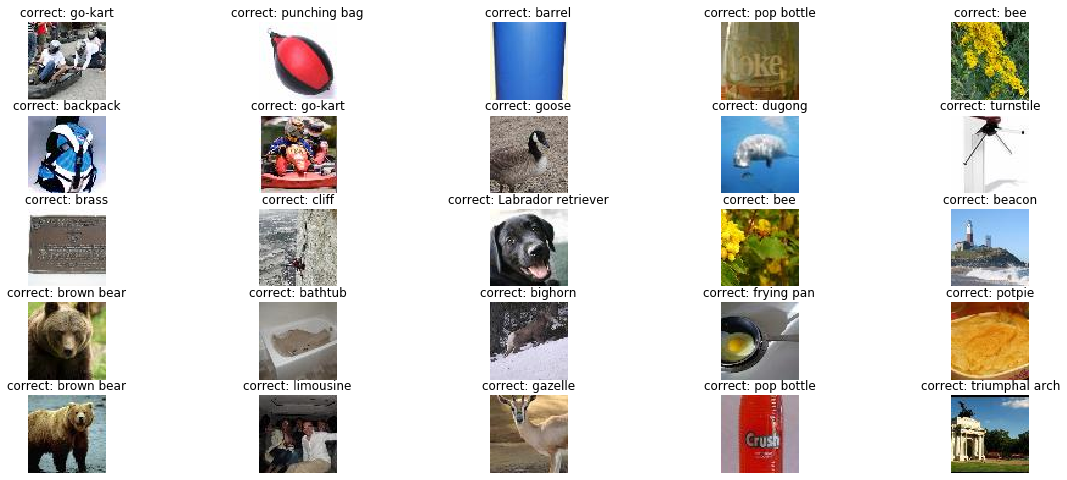

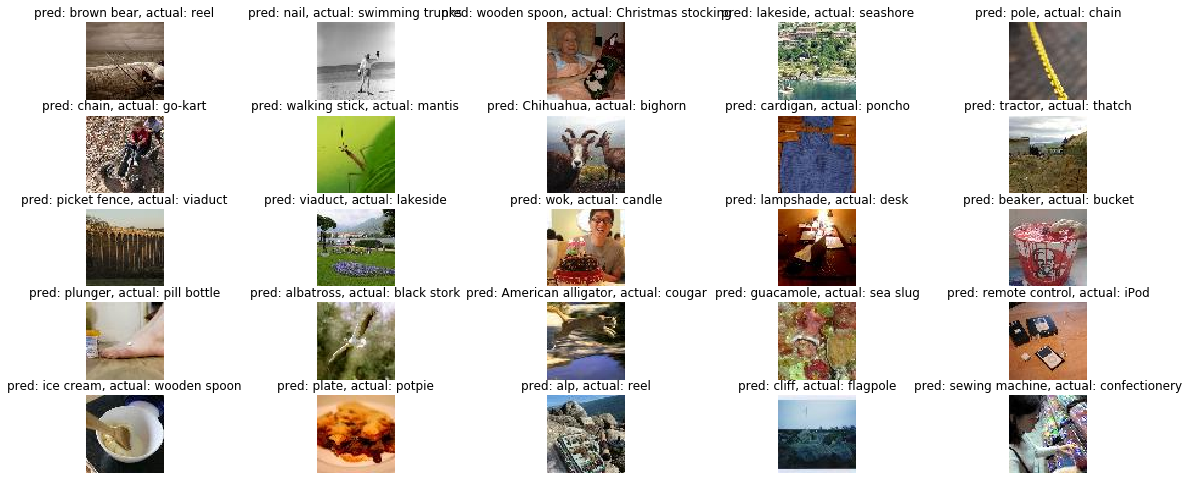

Thu Nov  7 06:39:28 2019 Train Epoch: 48 [0/100000 (0%)]	Loss: 0.058346
Thu Nov  7 06:39:51 2019 Train Epoch: 48 [12800/100000 (13%)]	Loss: 0.029652
Thu Nov  7 06:40:14 2019 Train Epoch: 48 [25600/100000 (26%)]	Loss: 0.061337
Thu Nov  7 06:40:36 2019 Train Epoch: 48 [38400/100000 (38%)]	Loss: 0.038419
Thu Nov  7 06:40:59 2019 Train Epoch: 48 [51200/100000 (51%)]	Loss: 0.048279
Thu Nov  7 06:41:22 2019 Train Epoch: 48 [64000/100000 (64%)]	Loss: 0.034522
Thu Nov  7 06:41:44 2019 Train Epoch: 48 [76800/100000 (77%)]	Loss: 0.047417
Thu Nov  7 06:42:07 2019 Train Epoch: 48 [89600/100000 (90%)]	Loss: 0.070697

Test set: Average loss: 1.9679, Accuracy: 4553/8000 (57%)

Saved /gdrive/My Drive/colab_files/homework2/tiny_imagenet/checkpoints/048.pt

Saving new best model w/ test acc:  56.9125
Thu Nov  7 06:42:40 2019 Train Epoch: 49 [0/100000 (0%)]	Loss: 0.033244
Thu Nov  7 06:43:03 2019 Train Epoch: 49 [12800/100000 (13%)]	Loss: 0.044148
Thu Nov  7 06:43:26 2019 Train Epoch: 49 [25600/100000 (2

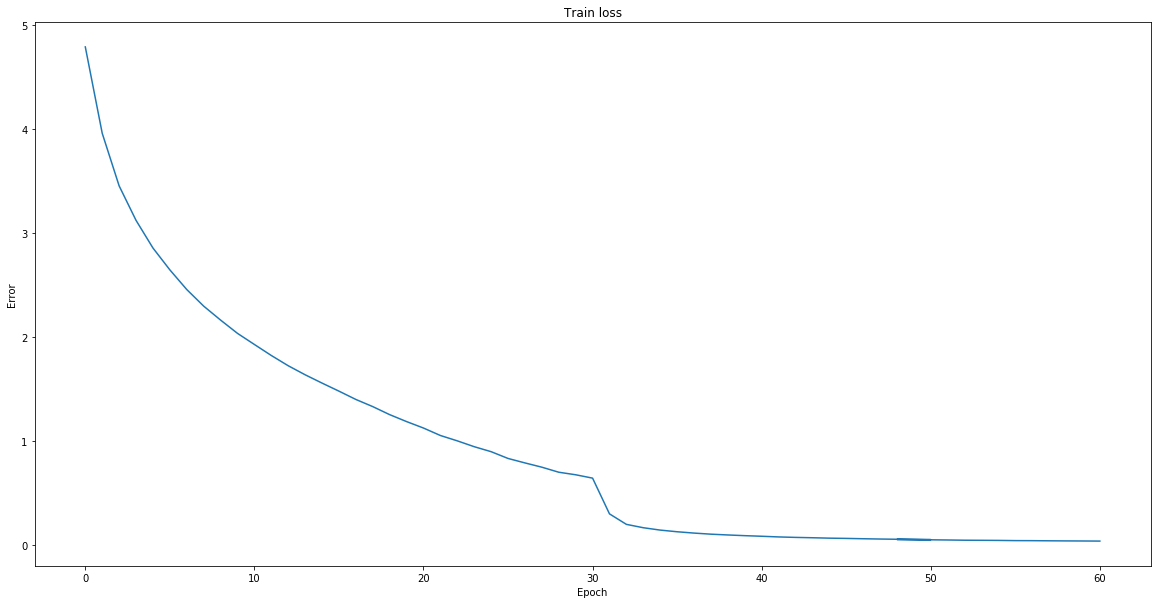

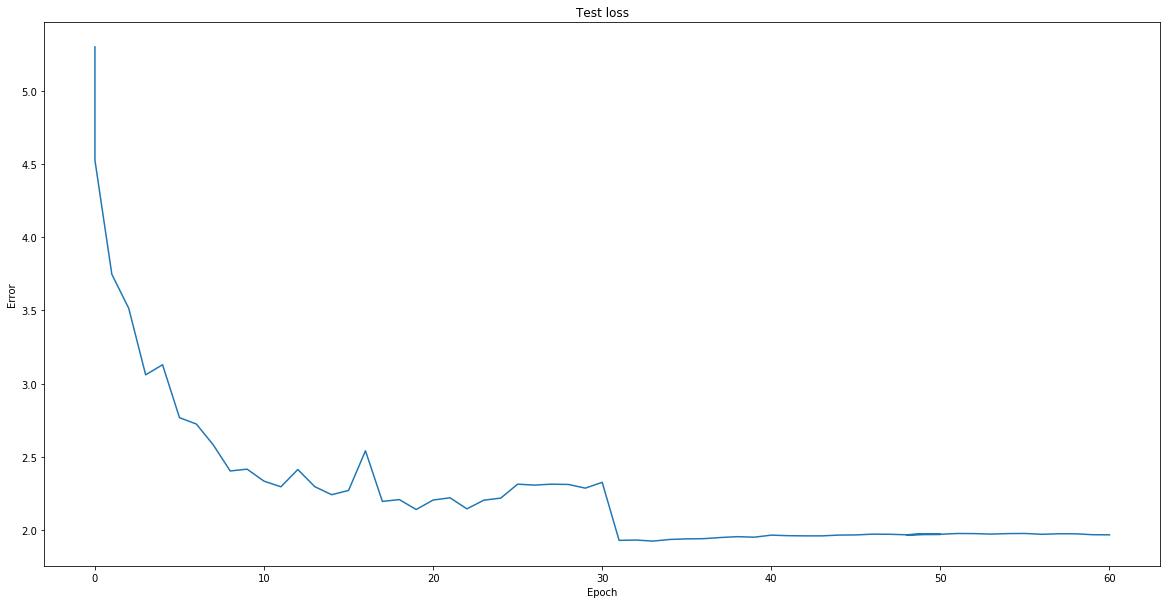

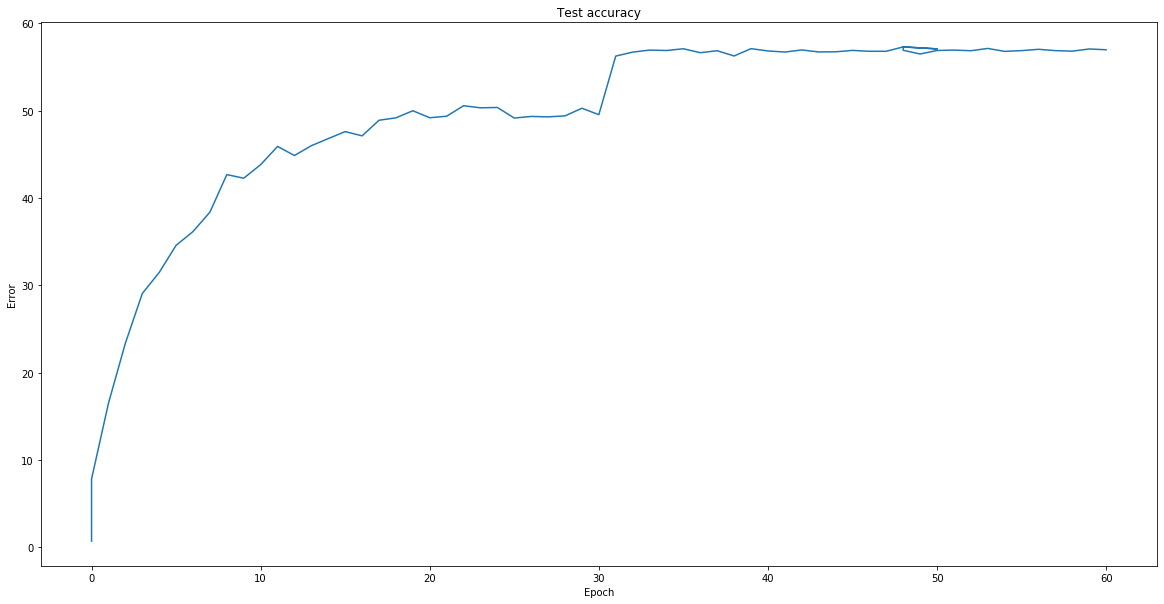

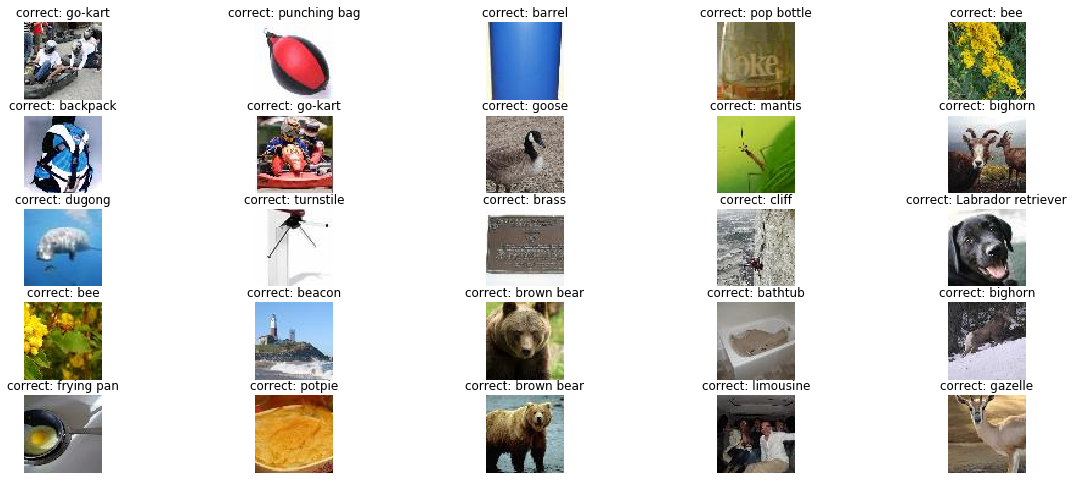

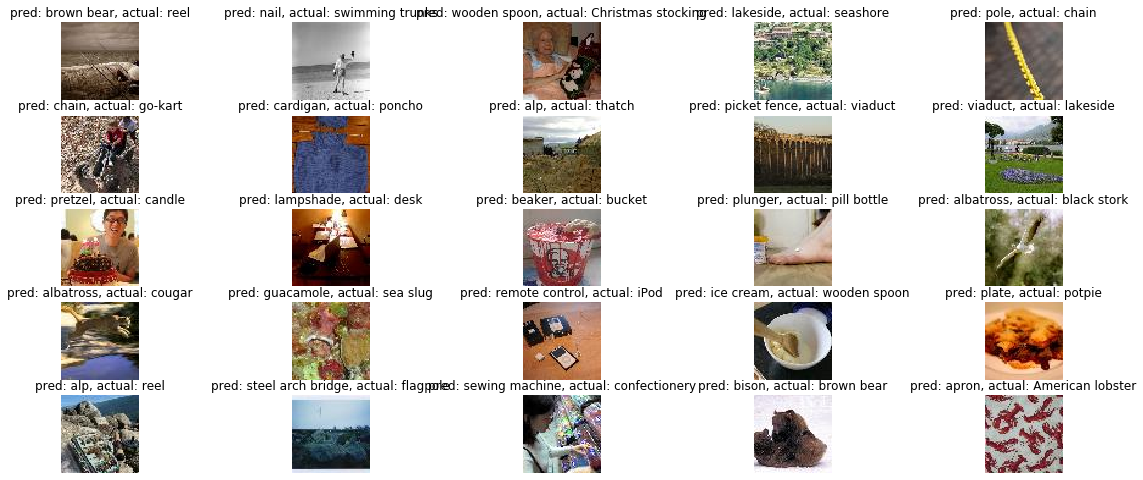

In [0]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 128
TEST_BATCH_SIZE = 10
EPOCHS = 60
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
LOG_PATH = DATA_PATH + 'log.pkl'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(DATA_PATH + 'checkpoints')

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH, ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        if epoch > 30:
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH, (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, DATA_PATH + 'checkpoints/%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(DATA_PATH + 'checkpoints/%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


In [0]:
# Load Model and Testing ONLY
TEST_BATCH_SIZE = 10
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100

use_cuda = USE_CUDA and torch.cuda.is_available()


device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]


test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet().to(device)
model_path = DATA_PATH + 'checkpoints/weights.pt'
_ = model.load_model(model_path)



test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

try:
    test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
except KeyboardInterrupt as ke:
    print('Interrupted')
finally:
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


# Short answer questions
Please answer these questions, and put the answers in a file called homework2_colab.pdf in your repository.

## CIFAR
1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.
2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.
3. Why do you think the best one worked well and the worst one worked poorly.


## TinyImageNet
1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from CIFAR question 1.
2. Were you able to use larger/deeper networks on TinyImageNet than you used on CIFAR and increase accuracy? If so, why? If not, why not?
3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet (32x32)? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

# Turn-in

Download your .ipynb and put it in your repository and name it homework2_colab.ipynb. Also remember to include your short answer questions with the name homework2_colab.pdf.

Lastly, please include the best weights for the TinyImageNet network such that they can be restored using pt_util by us. The weights will be stored in the checkpoint file (ie. 001.pt). You should verify that they can be restored before including them, and rename the file weights.pt. Put this file in the `hw2` directory.